# Integration of scRNA-seq data with substantial batch effects with SysVI

This tutorial shows how to integrate scRNA-seq datasets with substantial batch effects (here refered to as _systems_), such as cross-species, cross-technology (e.g. cells and nuclei), and primary tissue and _in vitro_ model system (e.g. organoid) datasets. In this tutorial we use the SysVI model that combines VampPrior and latent cycle-consistency loss on top of a cVAE to improve integration. 

For more details on this method please see our paper [Integrating single-cell RNA-seq datasets with substantial batch effects](https://doi.org/10.1101/2023.11.03.565463).

In [1]:
import scanpy as sc

import matplotlib.pyplot as plt

from scvi.external import SysVI

## Prepare data for integration

Integration should be performed on normalized and log-transformed data, which is in our case stored in X. We recomend that data should be subsetted to HVGs before integration. In our paper we selected HVGs per system (e.g. species) and then took intersection of genes across systems to finally obtain ~2000 HVGs. The here-used example data this was already preprocessed accordingly.

For integration we must define covariates to be corrected for by the model. The system covariate should represent the covariate capturing the substantial batch effects. Besides system covariate, any other relatively weaker batch effects of continous or categorical nature can be corrected for. This can be for example samples within systems, denoted by "batch" in the below example. 
If the number of batches is extensive, the one-hot encoding of batches via _categorical_covariate_keys_ would lead to large memory useage. In this case it may be beneficial to use covariate embedding via _categorical_covariate_embed_keys_ as previously proposed by [De Donno, et al. (2023)](https://doi.org/10.1038/s41592-023-02035-2).

In [2]:
# Load data
# This dataset can be obtained from https://github.com/theislab/cross_system_integration/tree/main/tutorials/data
adata=sc.read('../data/mouse-human_pancreas_subset10000.h5ad')

/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [3]:
# Setup adata for training
SysVI.setup_anndata(
    adata=adata,
    system_key='system',
    categorical_covariate_keys=['batch'],
)

INFO     Using column names from columns of adata.obsm['system']                                                   
INFO     Using column names from columns of adata.obsm['covariates']                                               


## Train the model

We suggest that the model with the VampPrior and latent cycle-consistency is used, as shown below. However, if desired, the prior can be changed to standard normal distribution or the number of prior components for VampPrior can be modified. To disable cycle-consistency you can set the _z_distance_cycle_weight_ to zero via _plan_kwargs_ in _train_.

```python
# Example showing how to adjust loss weights
model.train(
    plan_kwargs={
        "loss_weights":{
                "kl_weight": 1,
                "z_distance_cycle_weight": 0
    # Add additional parameters, such as number of epochs
}})
```

To increase batch corection you can increase cycle-consistency loss weight and to improve biological preservation you can decrease the KL loss weight or also cycle-consistency loss weight.

The number of epochs can be reduced when using a dataset with more cells. Please inspect the loss plots below to confirm that the number of epochs is sufficient for the loss to stabilise. 

In [4]:
# Initialise the model
model = SysVI( adata=adata)
# Train
max_epochs=200
model.train(
    max_epochs=max_epochs,
    # Parameters used for checking losses
    log_every_n_steps=1,
    check_val_every_n_epoch=1,
    val_check_interval=1.0
)

INFO     The model has been initialized                                                                            


/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/khrovati/miniconda/envs/scvi-dev/lib/pytho ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /om2/user/khrovati/miniconda/envs/scvi-dev/lib/pytho ...
LOCAL_RANK: 0 - CUDA_

Epoch 200/200: 100%|██████████| 200/200 [05:29<00:00,  1.58s/it, v_num=1, loss_train=-1.89e+5]

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [05:29<00:00,  1.65s/it, v_num=1, loss_train=-1.89e+5]


### Inspect the losses to assess if training was succesful

Training loss is plotted in blue and validation loss (held out random cells) in orange. The two losses will be similar due to the cells being randomly sampled into training/validation set without any stratification that would create trully distinct training/validation cell populations.

The top row shows the whole training history while the botom row shows a zoom-in into the epochs at the end of the training.

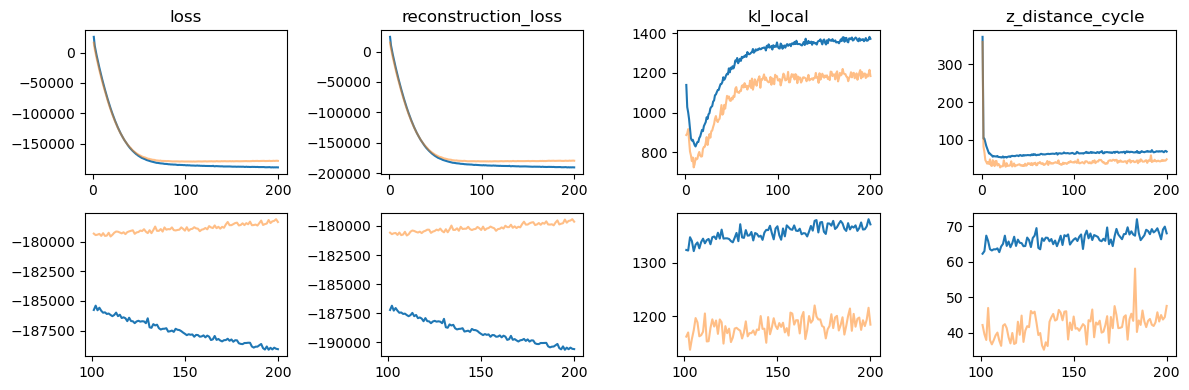

In [5]:
# Plot loses
# The plotting code below was specifcally adapted to the above specified model and its training
# If changing the model or training the plotting functions may need to be addapted accordingly

# Make detailed plot after N epochs
epochs_detail_plot=100
steps_detail_plot = epochs_detail_plot*int(
    model.trainer.logger.history['loss_validation'].shape[0]/max_epochs)
detail_plot=epochs_detail_plot

# Losses to plot
losses=[
     'loss_train',
     'reconstruction_loss_train',
     'kl_local_train',
     'z_distance_cycle_train']
fig,axs=plt.subplots(2,len(losses),figsize=(len(losses)*3,4))
for ax_i,l_train in enumerate(losses):
    l_val=l_train.replace('_train','_validation')
    l_name=l_train.replace('_train','')
    # Change idx of epochs to start with 1 so that below adjustment when 
    # train on step which only works for val leads to appropriate multiplication
    l_val_values=model.trainer.logger.history[l_val].copy()
    l_val_values.index=l_val_values.index+1
    l_train_values=model.trainer.logger.history[l_train].copy()
    l_train_values.index=l_train_values.index+1
    # This happens if log on step as currently this works only for val loss
    if l_train_values.shape[0]<l_val_values.shape[0]:
        l_train_values.index=\
            l_train_values.index*int(l_val_values.shape[0]/l_train_values.shape[0])
    for l_values,c,alpha,dp in [
        # Train loss logged on epoch in either case now
        (l_train_values,'tab:blue',1,epochs_detail_plot),
        (l_val_values,'tab:orange',0.5, detail_plot)]:
        axs[0,ax_i].plot( l_values.index,l_values.values.ravel(),c=c,alpha=alpha)
        axs[0,ax_i].set_title(l_name)
        axs[1,ax_i].plot(l_values.index[dp:],
                         l_values.values.ravel()[dp:],c=c,alpha=alpha)

fig.tight_layout()

## Integrated embedding

Below we show how to obtain the integrated embedding after the model is trained and visually assess cell type preservation and system integration. For more detailed evaluation examples and integration metrics see our [paper](https://doi.org/10.1101/2023.11.03.565463).

In [6]:
# Get embedidng - save it into X of new AnnData
embed= model.embed(adata=adata)
embed=sc.AnnData(embed,obs=adata.obs)
# Make system categorical for plotting below
embed.obs['system']=embed.obs['system'].map({0:'mouse',1:'human'})

Plot the integrated embedding with system and cell type inforamtion to assess the integration quality.

In [7]:
# Compute UMAP
sc.pp.neighbors(embed, use_rep='X')
sc.tl.umap(embed)

/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector

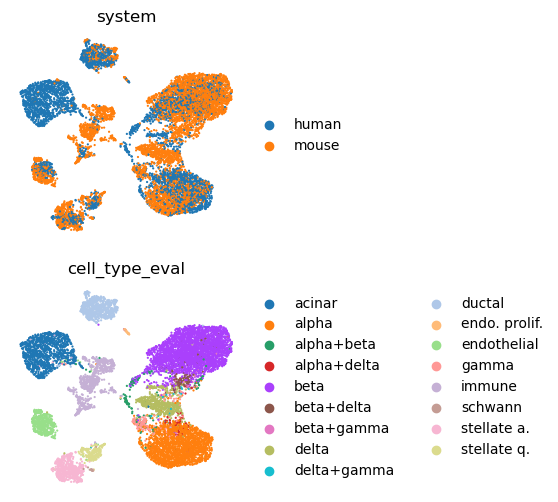

In [8]:
# Plot UMAP embedding

# Obs columns to color by
cols=['system','cell_type_eval']

# One plot per obs column used for coloring
fig,axs=plt.subplots(len(cols),1,figsize=(3,3*len(cols)))
for col,ax in zip(cols,axs):
    sc.pl.embedding(embed,'X_umap',color=col,s=10,ax=ax,show=False,sort_order=False,frameon=False)

To inspect cell type preservation and system integration in more detail we suggest plotting cell types separately per system.

/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:1251: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/om2/user/khrovati/miniconda/envs/scvi-dev/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data 

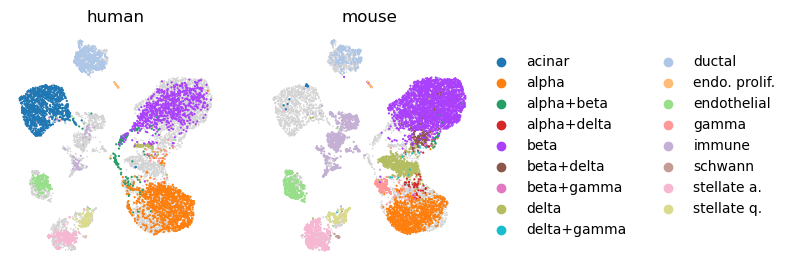

In [9]:
# Plot UMAP embedding per system
systems=sorted(embed.obs.system.unique())
ncols=len(systems)
# Plot systms side by side
fig,axs=plt.subplots(1,ncols,figsize=(3*ncols,3))
for i,system in enumerate(systems):
    ax=axs[i]
    # Plot all cells as background and on top cells from one system colored by cell type
    sc.pl.umap(embed, ax=ax,show=False,s=5,frameon=False)
    sc.pl.umap(embed[embed.obs.system==system,:],color='cell_type_eval',
               ax=ax,show=False,s=10,frameon=False,title=system)
    # Keep legend only on the last plot (assuming this legend contains all categories)
    if i!=ncols-1:
        ax.get_legend().remove()